In [1]:
import io
import sys
import json
import tqdm
import contextlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list
sys.path.insert(0, '..')
from mining import * 
from isf_helper import (extract_ms2_spectrum, 
                        get_comprehensive_stats_per_dataset, 
                        explain_a_dataset_by_mz_deltas, 
                        explain_a_dataset_byMS2)

In [5]:
# Input data 

tof_datasets = [x.rstrip() for x in open('selected_16_tof_datasets.txt').readlines()]
pos_tof_datasets = [x for x in tof_datasets if 'pos' in x]
neg_tof_datasets = [x for x in tof_datasets if 'neg' in x]

# dict_tablefiles = {}
# for line in open('list_input_files.tsv').readlines():
#     a = line.rstrip().split('\t')
#     dict_tablefiles[a[0]] = a[1]

dict_rtwindow = {}
for line in open('elution_parameters_16studies_tof.tsv').readlines()[1:]:
    a = line.rstrip().split('\t')
    dict_rtwindow[a[0]] = float(a[5])

In [3]:
# pos ionization
isotope_search_patterns_pos = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            # (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

isotope_search_patterns_neg = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            (1.9958, '32S/34S', (0, 0.1)), # 4%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            (32.026215, 'CH3OH')
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), 
                            (67.987424, 'NaCOOH'),
                            (82.0030, 'NaCH2COOH'),
                            # (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]
extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'CH3OH'),
                            (-35.037114, '-NH3-H2O'), # not incuded in candidates below
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

pos_candidate_fragments = '''18.01	113	18.010565	water	{'H': 2, 'O': 1}
14.015	83	14.015649	addition of acetic acid and loss of CO2.   Reaction: (+C2H2O2) and (-CO2)	{'C': 1, 'H': 2}
2.015	80	2.014552	2H	{'H': 2}
28.0305	59	28.0313	± C2H4, natural alkane chains such as fatty acids	{'C': 2, 'H': 4}
46.0055	54	46.00548	± CO+H2O (carboxylic acid)	{'C': 1, 'O': 2, 'H': 2}
17.0265	53	17.0265	addition of ammonia. Reaction: (+NH3)	{'N': 1, 'H': 3}
11.9995	45	12.0	methylation and reduction	{'C': 1}
44.0255	41	44.0262	hydroxyethylation	{'C': 2, 'H': 4, 'O': 1}
26.015	41	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	{'C': 2, 'H': 2}
15.995	40	15.99492	± O, e.g. oxidation/reduction	{'O': 1}
16.031	39	16.0313	Methylation + reduction	{'C': 1, 'H': 4}
32.026	37	32.026215	MeOH	{'C': 1, 'H': 4, 'O': 1}
39.993	37	39.9925	extra OH sodium adduct	{'H': 1, 'O': 1}
27.9945	37	27.9949	addition of CO. Reaction: (+CO)	{'C': 1, 'O': 1}
23.999	36	24.0	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
42.0465	35	42.04695	± C3H6, propylation	{'C': 3, 'H': 6}
9.984	32	9.98435	addition of CO and loss of water. Reaction: (+CO) and (-H2O)	{'C': 1, 'H': -2}
30.0105	31	30.010564	addition of acetic acid and loss of CO. Reaction: (+C2H2O2) and (-CO)	{'C': 1, 'H': 2, 'O': 1}
56.0625	30	56.0626	± C4H8, butylation	{'C': 4, 'H': 8}
13.979	30	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	{'H': -2, 'O': 1}
'''
pos_candidate_fragments = [
    (float(x.split()[0]), x) for x in pos_candidate_fragments.splitlines()
]
pos_isf_candidate_fragments = [x[0] for x in pos_candidate_fragments]

In [4]:
def assign_intensity_quartile(list_features):
    '''
    example feature : {'id_number': 'F101',
                'id': 'F101',
                'mz': 113.8853,
                'rtime': 261.81,
                'apex': 261.81,
                'left_base': 261.02,
                'right_base': 263.65,
                'parent_masstrack_id': '1034',
                'peak_area': '433995',
                'cSelectivity': '0.75',
                'goodness_fitting': '0.98',
                'snr': '3',
                'detection_counts': '39',
                'representative_intensity': '433995'}
    returns dict {fid: quartile, ...}
    '''
    for f in list_features:
        f['peak_area'] = float(f['peak_area'])
    d = {}
    intensities = np.array([f['peak_area'] for f in list_features])
    x1, x2, x3 = np.quantile(intensities, 0.75
                        ), np.quantile(intensities, 0.5
                         ), np.quantile(intensities, 0.25)
    
    for f in list_features:
        if f['peak_area'] > x1:
            d[f['id']] = 1  # 1st quartile
        elif x1 >= f['peak_area'] > x2:
            d[f['id']] = 2
        elif x2 >= f['peak_area'] > x3:
            d[f['id']] = 3
        else:
            d[f['id']] = 4
    return d

In [ ]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 5 minutes



# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 50 minutes

tally_pos = []
quartile_matches_pos = {}
for study in tqdm.tqdm(pos_tof_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'pos'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_tof/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_pos, 
                                adduct_search_patterns=adduct_search_patterns_pos,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=5,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )
    
        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, pos_isf_candidate_fragments, 
            rt_stdev=dict_rtwindow[study]
            )

        dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'quartile_matches': quartile_matches,
            }
        tally_pos.append(cur_tally)
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        quartile_matches_pos[study] = {
            'M0': [dict_intensity_quartile[x] for x in M0_ids],
            'isotope': [dict_intensity_quartile[x] for x in isotope_ids],
            'fragment': [dict_intensity_quartile[x] for x in fragment_ids],
            'singletons': [dict_intensity_quartile[x] for x in singleton_ids],
        }
        round_id = '01292025_1'
        os.makedirs(f'output/{round_id}/pos/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output/{round_id}/pos/{study}/ecpds.json', 'w'))
        json.dump(cur_tally, open(f'output/{round_id}/pos/{study}/tally.json', 'w'))
        json.dump(quartile_matches_pos[study], open(f'output/{round_id}/pos/{study}/quartile_matches.json', 'w'))

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', '06jun12_60-r001', '04jun12_13-r001', '04jun12_13-r002', '04jun12_13-r003', '04jun12_13-r004', '04jun12_13-r005', '04jun12_13-r006', '04jun12_13-r007', '04jun12_13-r008']
Read 4173 feature lines


Multiple charges considered: [1, 2, 3]


Khipu search grid: 
               M+H+       Na/H       MeOH        K/H        ACN     NaCOOH
M0         1.007276  22.989216  33.033491  38.963158  42.033825  68.994700
13C/12C    2.010631  23.992571  34.036846  39.966513  43.037180  69.998055
13C/12C*2  3.013986  24.995926  35.040201  40.969868  44.040535  71.001410
Constructed 368 khipus in this round.


Khipu search grid: 
                       M+H+, 2x charged  Na/H, 2x charged  MeOH, 2x charged  \
M0                             0.503638         11.998246         17.020384   
13C/12C, 2x charged         

In [15]:
test0 = tally_pos[0]['quartile_matches']
tally_pos[0]['num_features'], [
    len([x for x in test0 if x ==1]), len([x for x in test0 if x ==2]), 
    len([x for x in test0 if x ==3]), len([x for x in test0 if x ==4]),
]

(4173, [463, 219, 168, 128])

In [16]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 

preannotated_features = [len(x['quartile_matches']) for x in tally_pos]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_pos]

quartile_percs = [[], [], [], []]
for x in tally_pos:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for ii in range(4):
        quartile_percs[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)
    
median_perc = [np.median(quartile_percs[ii]) for ii in range(4)]
median_perc

[44.28429195746809, 17.743204563548023, 12.693446088794927, 10.228329809725158]

5513.5 2294.5


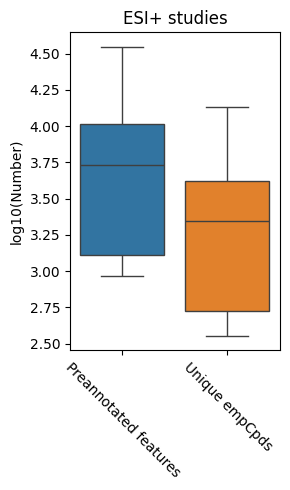

In [17]:
# Fig 3a. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
}

print(np.median(preannotated_features), np.median(unique_empCpds))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.set_title("ESI+ studies")
plt.tight_layout()
plt.savefig('Fig3a_preannotation_pos.pdf')

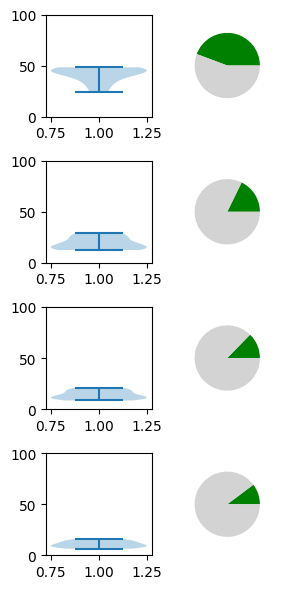

In [18]:
# Fig. 3b. distribution of perc; pie chart for median pec
# plot barplot for 
piedata = [(x, 100-x) for x in median_perc]

fig, axs = plt.subplots(4, 2, figsize=(3, 6))
for ii in range(4):
    axs[ii, 0].violinplot(quartile_percs[ii]) #, color='lg')
    axs[ii, 0].set_ylim(0, 100)
    axs[ii, 1].pie(piedata[ii], colors=['green', 'lightgray'], radius=.8) 
    
plt.tight_layout()
plt.savefig("Fig3b_preannotation_pos_piecharts.pdf")

## Do neg ion studies

In [13]:
neg_candidate_fragments = '''67.9875	140	67.987424	NaCOOH	"{'C': 1, 'O': 2, 'Na': 1, 'H': 1}"
2.015	70	2.014552	2H	{'H': 2}
135.974	49	135.974848	2X NaCOOH	"{'C': 2, 'O': 4, 'H': 2, 'Na': 2}"
82.002	48	82.003035	methylation and addition of trifluoromethyl. Reaction: (+CH2) and (+CF3-H)	"{'C': 2, 'H': 1, 'F': 3}"
1.011	41	1.007276467	1H	{'H':1 }
0.996	39	0.996585	addition of Guanine and loss of D-ribose. Reaction: (+C5H3N5) and (-C5H8O4)	"{'H': -5, 'N': 5, 'O': -4}"
43.989	35	43.9898	addition of CO2. Reaction: (+CO2)	"{'C': 1, 'O': 2}"
14.015	32	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	"{'C': 1, 'H': 2}"
46.005	31	46.005305	addition of Phosphate and dechlorination. Reaction: (+HPO3) and (-Cl+H)	"{'H': 2, 'O': 3, 'P': 1, 'Cl': -1}"
26.015	29	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	"{'C': 2, 'H': 2}"
61.97	29	61.975755	addition of Phosphate and defluorination. Reaction: (+HPO3) and (-F+H)	"{'H': 2, 'O': 3, 'P': 1, 'F': -1}"
129.957	29	129.958482	addition of di-phosphate and denitrification. Reaction: (+H2P2O6) and (NO2 -> NH2)	"{'H': 4, 'O': 4, 'P': 2}"
60.021	29	-60.0211	desmolysis	"{'C': -2, 'H': -4, 'O': -2}"
74.0365	28	74.03678	propionylation	"{'C': 3, 'H': 6, 'O': 2}"
23.9995	27	24	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
10.029	27	10.028802	addition of CO2 and dechlorination. Reaction: (+CO2) and (-Cl+H)	"{'C': 1, 'H': 1, 'O': 2, 'Cl': -1}"
44.026	26	44.0262	hydroxyethylation	"{'C': 2, 'H': 4, 'O': 1}"
18.0105	26	18.010565	water	"{'H': 2, 'O': 1}"
6.0165	24	6.010565	addition of tiglyl and loss of phenyl. Reaction: (+C5H6O) and (-C6H5+H)	"{'C': -1, 'H': 2, 'O': 1}"
15.994	23	15.9949	oxidation	{'O': 1}
'''
neg_candidate_fragments = [
    (float(x.split()[0]), x) for x in neg_candidate_fragments.splitlines()
]

isf_candidate_fragments_neg = [x[0] for x in neg_candidate_fragments]

In [ ]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 2 minutes

tally_neg = []
for study in neg_orbi_datasets:
    ion_mode = 'neg'
    _n, list_features = read_features_from_asari_table(
        open(f'../input_data_tof/{study}/full_feature_table.tsv').read()
        )
    for f in list_features:
        f['representative_intensity'] = f['peak_area']
    list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                            list_features, 
                            isotope_search_patterns=isotope_search_patterns, 
                            adduct_search_patterns=adduct_search_patterns_neg,
                            extended_adducts=extended_adducts, 
                            mz_tolerance_ppm=5,
                            rt_tolerance=dict_rtwindow[study],
                            mode=ion_mode,
                            charges=[1, 2, 3],
                            )
    # convert khipu instances to dicts
    list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                         key=lambda x: x['neutral_formula_mass'], reverse=True)
    remaining_features = [f for f in list_features if f['id'] not in all_assigned_fids]
    
    # by isf_candidate_fragments
    explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
        list_khipus, remaining_features, isf_candidate_fragments_neg, 
        rt_stdev=dict_rtwindow[study]
        )

    dict_intensity_quartile = assign_intensity_quartile(list_features)
    preannotated_feature_ids = set(list(all_assigned_fids) + explained_feature_ids)
    quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

    tally_neg.append(
        {
            'study': study,
            'num_khipus': len(list_khipus),
            'num_features':  len(list_features),
            'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
            'mzdelta_explained_features': len(set(explained_feature_ids)),
            'quartile_matches': quartile_matches,
        }
    )

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', '20180810-EX00864-A003-IN0026-MB-CS0000007-2-N', '20180810-EX00864-A003-IN0026-MB-CS0000007-1-N', '20180810-EX00864-A003-IN0026-MB-CS0000007-3-N', '20180810-EX00864-A003-IN0026-N1-CS0000091-1-N', '20180810-EX00864-A003-IN0026-N1-CS0000091-2-N', '20180810-EX00864-A003-IN0026-N1-CS0000091-3-N', '20180810-EX00864-A003-IN0026-N1-CS0000091-4-N', '20180810-EX00864-A003-IN0026-N1-CS0000091-5-N', '20180810-EX00864-A003-IN0026-N1-CS0000091-6-N']
Read 84791 feature lines


Multiple charges considered: [1, 2, 3]


Khipu search grid: 
               M-H-       Na/H        K/H        ACN     NaCOOH      C2HF3
M0        -1.007276  20.974664  36.948606  40.019273  66.980148  80.995724
13C/12C   -0.003921  21.978019  37.951961  41.022628  67.983503  81.999079
13C/12C*2  0.999434  22.981374  38.955316  42.0259

In [19]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 

preannotated_features = [len(x['quartile_matches']) for x in tally_neg]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_neg]

quartile_percs = [[], [], [], []]
for x in tally_neg:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for ii in range(4):
        quartile_percs[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)
    
median_perc = [np.median(quartile_percs[ii]) for ii in range(4)]
median_perc

[47.80049471833236, 24.619969387245888, 17.877097765572927, 12.922381525004168]

4927.0 1878.0


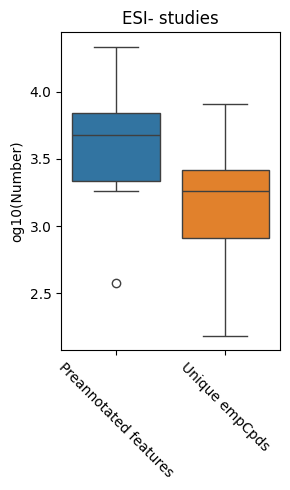

In [20]:
# Fig 3c. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
}

print(np.median(preannotated_features), np.median(unique_empCpds))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("og10(Number)")
ax.set_title("ESI- studies")
plt.tight_layout()
plt.savefig('Fig3c_preannotation_neg.pdf')

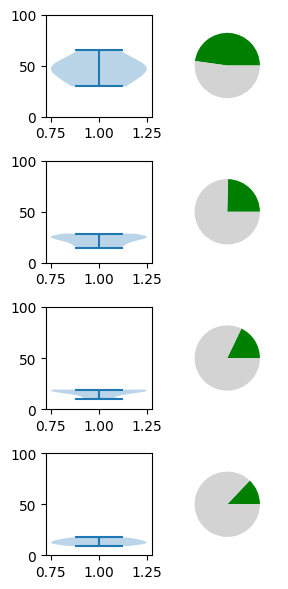

In [21]:
# Fig. 3d. distribution of perc; pie chart for median pec
# plot barplot for 
piedata = [(x, 100-x) for x in median_perc]

fig, axs = plt.subplots(4, 2, figsize=(3, 6))
for ii in range(4):
    axs[ii, 0].violinplot(quartile_percs[ii]) #, color='lg')
    axs[ii, 0].set_ylim(0, 100)
    axs[ii, 1].pie(piedata[ii], colors=['green', 'lightgray'], radius=.8) 
    
plt.tight_layout()
plt.savefig("Fig3d_preannotation_neg_piecharts.pdf")

# Conclusion

This notebook plots Figure 3. 

Numbers of pre-annotated features by extended khipus in all studies.
a,b. Distribution of numbers of pre-annotated features, median value 17,499 and 17,974 for positive and negative ionization datasets, respectively. They correspond to 5,675 and 6,224 unique empirical compounds, respectively.

 c,d. Percentage distribution of pre-annotated features in each intensity quartile in each study, for positive and negative ionization datasets, respectively. The pie charts show median percentage in each quartile, respectively. 